In [ ]:
pip install tensorflow==2.15.1 tf-keras==2.15.1 kagglehub==0.3.4

_________________________________________________________________
1 Physical GPUs, 1 Logical GPUs
_________________________________________________________________
Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 batch_normalization_1044 (  (None, 2048)              8192      
 BatchNormalization)                                             
                                                                 
 dense_20 (Dense)            (None, 256)               524544    
                                                                 
 dropout_10 (Dropout)        (None, 

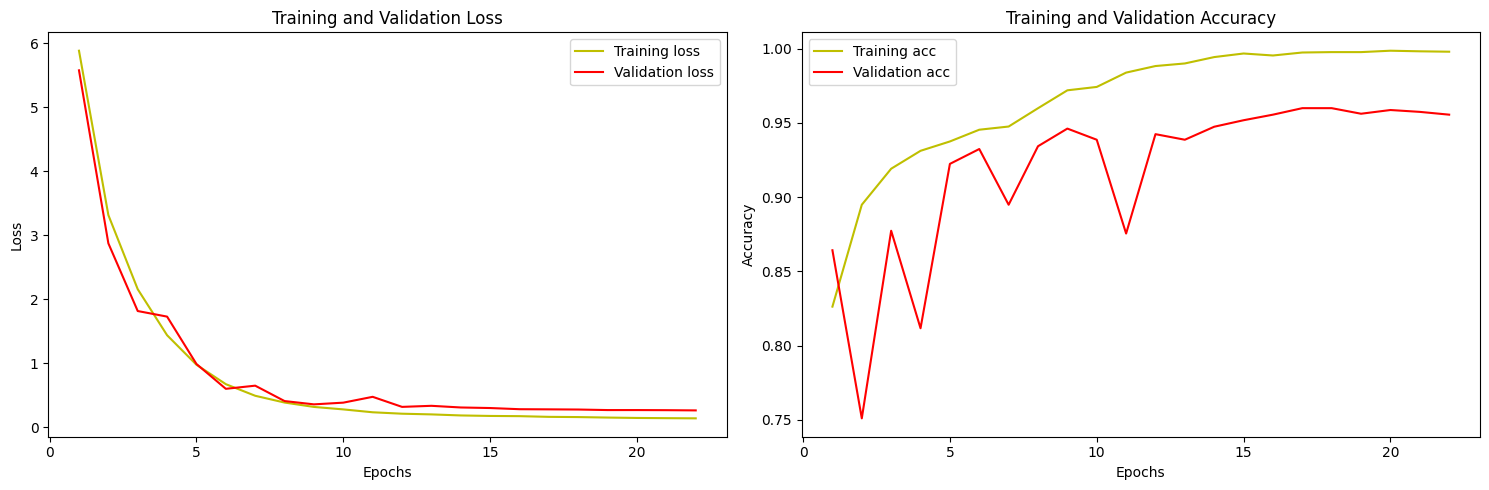

Evaluating Model:
20/20 [==============================] - 6s 299ms/step - loss: 0.2630 - accuracy: 0.9550
Training Loss: 0.151658296585083, Training Accuracy: 1.0
Validation Loss: 0.2634041905403137, Validation Accuracy: 0.9587500095367432
Testing Loss: 0.2629713714122772, Testing Accuracy: 0.9549999833106995


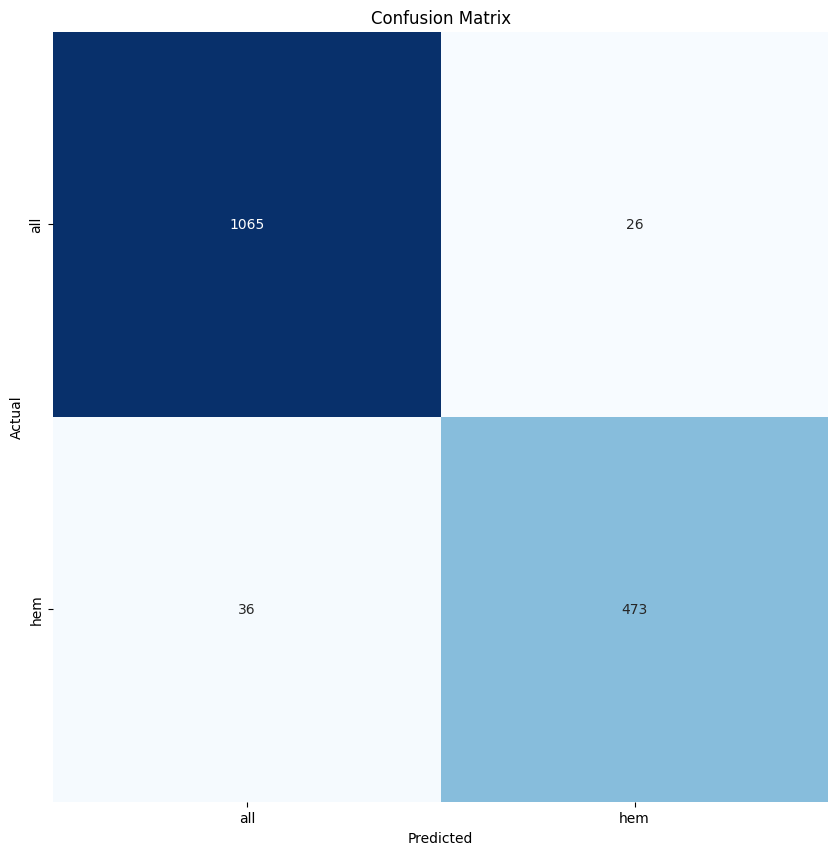

Classification Report:
              precision    recall  f1-score   support

         all       0.97      0.98      0.97      1091
         hem       0.95      0.93      0.94       509

    accuracy                           0.96      1600
   macro avg       0.96      0.95      0.96      1600
weighted avg       0.96      0.96      0.96      1600



In [12]:

import os
import platform
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")


def setup_gpus():
    gpus = tf.config.experimental.list_physical_devices("GPU")
    print("_________________________________________________________________")
    if gpus:
      try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        print("error", e)
    else:
      print("No gpu found, training on cpu")
    print("_________________________________________________________________")


def get_df(path):
    path = os.path.join(path, "training_data")
    images_paths = []
    labels = []
    for folder in os.listdir(path):
        for label in os.listdir(os.path.join(path, folder)):
            for image in os.listdir(os.path.join(path, folder, label)):
                image_path = os.path.join(path, folder, label, image)
                images_paths.append(image_path)
                labels.append(label)

    df = pd.DataFrame()
    df["filepath"] = images_paths
    df["label"] = labels
    return df


def download_dataset():
    path = kagglehub.dataset_download("andrewmvd/leukemia-classification")
    path = os.path.join(path, "C-NMC_Leukemia")
    return path


def setup_df():
    path = download_dataset()
    df = get_df(path)
    return df


def create_df():
    df = setup_df()

    stratified = df["label"]
    training_df, validation_test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=stratified)

    stratified = validation_test_df["label"]
    validation_df, testing_df = train_test_split(validation_test_df, train_size=0.5, shuffle=True, random_state=123, stratify=stratified)

    return training_df, validation_df, testing_df


def parse_images(training_df, validation_df, testing_df, batch_size):

    training_gen = ImageDataGenerator(horizontal_flip=True)
    testing_gen = ImageDataGenerator()

    training_set = training_gen.flow_from_dataframe(
        training_df, x_col="filepath", y_col="label", target_size=(224, 224), class_mode="categorical", color_mode="rgb", shuffle=True, batch_size=batch_size
    )

    validation_set = testing_gen.flow_from_dataframe(
        validation_df, x_col="filepath", y_col="label", target_size=(224, 224), class_mode="categorical", color_mode="rgb", shuffle=True, batch_size=batch_size
    )

    testing_set = testing_gen.flow_from_dataframe(
        testing_df, x_col="filepath", y_col="label", target_size=(224, 224), class_mode="categorical", color_mode="rgb", shuffle=False, batch_size=batch_size
    )

    return training_set, validation_set, testing_set


class SetupCallback(keras.callbacks.Callback):

    def __init__(self, model, patience, stop_patience, threshold, factor, model_path):
        super(SetupCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.thresholf = threshold
        self.factor = factor
        self.model_path = model_path

    def get_callbacks(self):
        callbacks = [self, self.setup_model_checkpoint(), self.setup_early_stopping(), self.setup_reduce_lr()]
        return callbacks

    def setup_model_checkpoint(self):
        path = self.model_path + "model-epoch-{epoch:02d}.keras"
        model_checkpoint = keras.callbacks.ModelCheckpoint(
            path,
            monitor="val_loss",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            initial_value_threshold=None,
        )
        return model_checkpoint

    def setup_early_stopping(self):
        early_stopping = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0.01,
            patience=self.stop_patience,
            verbose=True,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
            start_from_epoch=3,
        )
        return early_stopping

    def setup_reduce_lr(self):
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=self.factor, patience=self.patience, verbose=0, mode="auto", min_delta=0.0001, cooldown=0, min_lr=0.0)
        return reduce_lr


def setup_model():
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling="max")

    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(l=0.017184), activity_regularizer=regularizers.l1(0.005945), bias_regularizer=regularizers.l1(0.005945), activation="relu"))
    model.add(tf.keras.layers.Dropout(rate=0.5, seed=123))
    model.add(tf.keras.layers.Dense(2, activation="softmax"))

    return model


def setup_optimizer():
    if platform.system() == "Darwin" and platform.processor() == "arm":
        opt = tf.keras.optimizers.legacy.Adamax(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
    return opt


def setup_callbacks(model):
    model_path = "/content/drive/MyDrive/model/"
    patience = 1
    stop_patience = 3
    threshold = 0.9
    factor = 0.5
    epochs = 40
    setup_callbacks = SetupCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold, factor=factor, model_path=model_path)
    callbacks = setup_callbacks.get_callbacks()
    return callbacks, epochs


def evaluate_model(model, testing_df, training_set, validation_set, testing_set):
    print("Evaluating Model:")
    training_score = model.evaluate(training_set, steps=20, verbose=1)
    validation_score = model.evaluate(validation_set, steps=20, verbose=1)
    testing_score = model.evaluate(testing_set, steps=20, verbose=1)

    print(f"Training Loss: {training_score[0]}, Training Accuracy: {training_score[1]}")
    print(f"Validation Loss: {validation_score[0]}, Validation Accuracy: {validation_score[1]}")
    print(f"Testing Loss: {testing_score[0]}, Testing Accuracy: {testing_score[1]}")

    predictions = model.predict_generator(testing_set)
    label_predictions = np.argmax(predictions, axis=1)

    class_indices = testing_set.class_indices
    classes = list(class_indices.keys())

    conf_matrix = confusion_matrix(testing_set.classes, label_predictions)
    plot_confusion_matrix(conf_matrix, classes)
    print("Classification Report:")
    print(classification_report(testing_set.classes, label_predictions, target_names=classes))


def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


def plot_loss_and_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history.history['loss']) + 1)
    ax1.plot(epochs, history.history['loss'], 'y', label='Training loss')
    ax1.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, history.history['accuracy'], 'y', label='Training acc')
    ax2.plot(epochs, history.history['val_accuracy'], 'r', label='Validation acc')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


def main():
    setup_gpus()

    training_df, validation_df, testing_df = create_df()
    batch_size = 40
    training_set, validation_set, testing_set = parse_images(training_df, validation_df, testing_df, batch_size)

    model = setup_model()

    optimizer = setup_optimizer()

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    callbacks, epochs = setup_callbacks(model)

    history = model.fit(x=training_set, epochs=epochs, callbacks=callbacks, validation_data=validation_set, validation_steps=None, shuffle=False)

    plot_loss_and_accuracy(history)

    evaluate_model(model, testing_df, training_set, validation_set, testing_set)


main()